In [48]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
# Path to the FASTA file (ensure the correct filename)
fasta_path = 'sequences.fasta'

# Initialize sets
char_set = set()
type_set = set()

# Read and parse the FASTA file
with open(fasta_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith('>'):
            # Parse header: species|accession|type|variant
            parts = line[1:].split('|')
            if len(parts) >= 3:
                type_set.add(parts[2])
        else:
            # Sequence line: collect characters
            char_set.update(line)

# Ensure '-' is included
char_set.add('-')

vocab = char_set.union(type_set)

print(f"Number of elements in vocab: {len(vocab)}")

Number of elements in vocab: 28


In [50]:
pip install Bio

Note: you may need to restart the kernel to use updated packages.


In [51]:
from Bio import SeqIO

char_set = set()
type_set = set()

for rec in SeqIO.parse('sequences.fasta', 'fasta'):
    # rec.id is like “Drosophila|NP_724343.1|H2A|cH2A”
    species, acc, htype, variant = rec.id.split('|')
    type_set.add(htype)
    char_set.update(str(rec.seq))

char_set.add('-')
vocab = char_set | type_set


In [52]:
rows = []
for rec in SeqIO.parse('sequences.fasta', 'fasta'):
    species, acc, htype, variant = rec.id.split('|')
    rows.append({
        'species': species,
        'accession': acc,
        'histone_type': htype,
        'variant': variant,
        'sequence': str(rec.seq)
    })

import pandas as pd
df = pd.DataFrame(rows)


In [53]:
df

,species,accession,histone_type,variant,sequence
0,Caenorhabditis,NP_505463.1,H2A,cH2A,----------------------------------------------...
1,Ixodes,EEC09557.1,H2A,cH2A,----------------------------------------------...
2,Drosophila,NP_724343.1,H2A,cH2A,----------------------------------------------...
3,Apis,XP_001119899.1,H2A,cH2A,----------------------------------------------...
4,Nematostella,EDO48405.1,H2A,cH2A,----------------------------------------------...
...,...,...,...,...,...
560,Homo,NP_005313.1,H1,H1.5,----------------------------------------------...
561,Homo,NP_005314.2,H1,H1.6,----------------------------------------------...
562,Homo,NP_861453.1,H1,H1.7,----------------------------------------------...
563,Homo,NP_005316.1,H1,H1.1,----------------------------------------------...


In [54]:
# Build vocab: characters from sequences + histone types
char_set = set(['-'])
df['sequence'].apply(lambda s: char_set.update(list(s)))
type_set = set(df['histone_type'])
vocab = char_set.union(type_set)

print("Vocab size:", len(vocab))
print("Vocab elements:", sorted(vocab))

Vocab size: 28
Vocab elements: ['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'H1', 'H2A', 'H2B', 'H3', 'H4', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']


In [55]:
char_set = set('-')
df['sequence'].apply(lambda s: char_set.update(list(s)))
type_set = set(df['histone_type'])
vocab = sorted(char_set.union(type_set))

dict1 = {ch: i for i, ch in enumerate(vocab)}
dict2 = {i: ch for i, ch in enumerate(vocab)}

encoded_seqs = [np.array([dict1[c] for c in seq], dtype=np.int64) for seq in df['sequence']]
encoded_targets = np.array([dict1[ht] for ht in df['histone_type']], dtype=np.int64)

print("Number of sequences:", len(encoded_seqs))

Number of sequences: 565


In [56]:
import torch
import torch.nn as nn

embedding_dim = 5
hidden_dim = 9
vocab_size = len(vocab)

class RNNWithAttentionModel(nn.Module):
   def __init__(self, random_seed=5):
       super(RNNWithAttentionModel, self).__init__()
       torch.manual_seed(random_seed)
       torch.cuda.manual_seed(random_seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False
       # Create an embedding layer for the vocabulary
       self.embedding = nn.Embedding(vocab_size, embedding_dim)
       # Create an RNN layer
       self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True) #single rnn layer
       # Apply a linear transformation to get the attention scores
       self.attention = nn.Linear(hidden_dim, 1)
       self.fc = nn.Linear(hidden_dim, vocab_size)
       
   def forward(self, x):
       x = self.embeddings(x)
       out, _ = self.rnn(x)
       attention_out = self.attention(out).squeeze(2)
       #  Get the attention weights
       attn_weights = torch.softmax(attention_out, dim=1) # → (batch, seq_len)
       # Compute the context vector
       context = torch.bmm(
            attn_weights.unsqueeze(1),  # → (batch, 1, seq_len)
            out                         # → (batch, seq_len, hidden_dim)
            ).squeeze(1)                # → (batch, hidden_dim)
       out = self.fc(context)
       
       return out

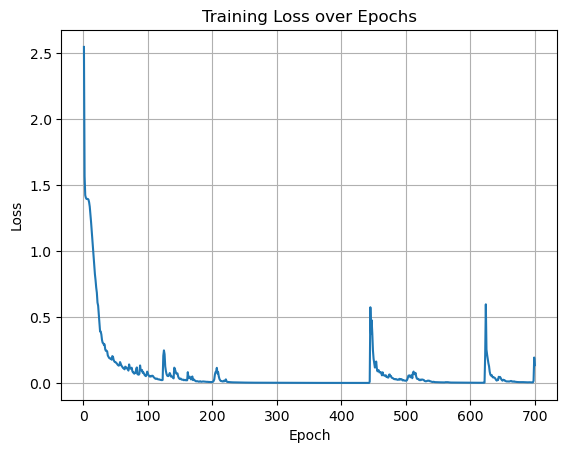

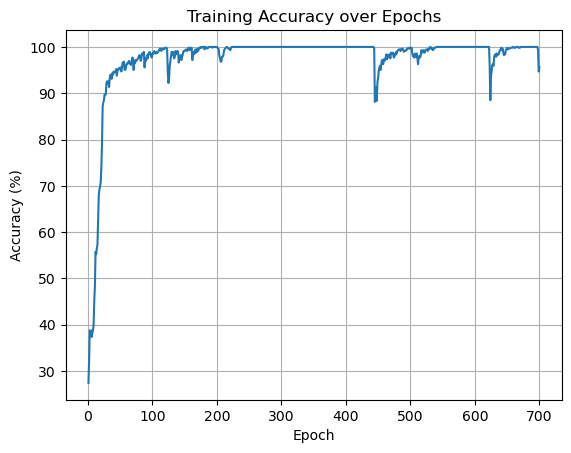

In [57]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

n_epochs    = 700
batch_size  = 32
lr          = 0.01
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


X = torch.stack([torch.tensor(s, dtype=torch.long) for s in encoded_seqs])  # (n_samples, seq_len)
y = torch.tensor(encoded_targets, dtype=torch.long)                        # (n_samples,)

dataset = TensorDataset(X, y)
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = RNNWithAttentionModel(random_seed=5).to(device)
model.embeddings = model.embedding

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

history = {'loss': [], 'acc': []}

for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    correct    = 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss   = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()

    avg_loss = total_loss / len(dataset)
    acc      = correct / len(dataset) * 100
    history['loss'].append(avg_loss)
    history['acc'].append(acc)
    
epochs = list(range(1, len(history['loss']) + 1))

plt.figure()
plt.plot(epochs, history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, history['acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.show()


In [58]:
final_loss = history['loss'][-1]
final_acc  = history['acc'][-1]
print(f"Final epoch ({n_epochs}) — loss: {final_loss:.4f}, accuracy: {final_acc:.2f}%")

Final epoch (700) — loss: 0.1346, accuracy: 95.58%


In [59]:
losses_after_100 = history['loss'][100:]           # epochs 101…700
max_loss = max(losses_after_100)
print(f"Max loss after epoch 100: {max_loss:.4f}")
print("All losses ≤ 0.5?", max_loss <= 0.5)

Max loss after epoch 100: 0.5964
All losses ≤ 0.5? False


In [60]:
seq_fasta = '''>Pan|XP_003311177.1|HTYPE|HVARIANT
MSGRGKQGGKARTKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK'''

lines    = seq_fasta.strip().splitlines()
sequence = ''.join(lines[1:]).replace(' ', '')


try:
    seq_idx = [dict1[ch] for ch in sequence]
except KeyError as e:
    raise ValueError(f"Unknown character in sequence: {e}")

seq_tensor = torch.tensor([seq_idx], dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    logits = model(seq_tensor)               # → shape (1, vocab_size)
    pred_idx = logits.argmax(dim=1).item()   # scalar index


predicted_token = dict2[pred_idx]
print("Predicted histone type:", predicted_token)

Predicted histone type: H2A
